In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

C:\Users\SuSu\Anaconda3\envs\jarvis\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# Dataset path and view possible targets
dataset_path = 'C:\\Users\\SuSu\\Desktop\\asr\\data'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

go
stop


In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['go', 'stop']


In [4]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)

ValueError: list.remove(x): x not in list

In [5]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

3880
3872
Total samples: 7752


In [6]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000 # .wev file sampled in 16kHz 
num_mfcc = 16
len_mfcc = 16

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

C:\Users\SuSu\Desktop\asr\data\go
C:\Users\SuSu\Desktop\asr\data\stop


In [8]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.])]
3880
3872


In [9]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [10]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [11]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

7752
7752


In [12]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [13]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [14]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [16]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 13 (16, 8)
Dropped: 19 (16, 12)
Dropped: 44 (16, 4)
Dropped: 51 (16, 11)
Dropped: 78 (16, 15)
Dropped: 83 (16, 8)
Dropped: 99 (16, 15)
Dropped: 133 (16, 15)
Dropped: 146 (16, 9)
Dropped: 205 (16, 7)
Dropped: 231 (16, 6)
Dropped: 250 (16, 11)
Dropped: 263 (16, 15)
Dropped: 285 (16, 11)
Dropped: 308 (16, 12)
Dropped: 311 (16, 13)
Dropped: 317 (16, 9)
Dropped: 333 (16, 15)
Dropped: 338 (16, 12)
Dropped: 360 (16, 15)
Dropped: 363 (16, 10)
Dropped: 372 (16, 11)
Dropped: 400 (16, 9)
Dropped: 401 (16, 11)
Dropped: 413 (16, 12)
Dropped: 417 (16, 15)
Dropped: 444 (16, 10)
Dropped: 448 (16, 11)
Dropped: 463 (16, 15)
Dropped: 474 (16, 13)
Dropped: 475 (16, 13)
Dropped: 496 (16, 14)


In [17]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.064


In [18]:
!pip install playsound

MFCCs: [[-4.22833003e+01 -3.31799534e+01 -3.05533762e+01 -3.15172601e+01
  -3.41386776e+01 -3.87514126e+01 -4.36848222e+01 -5.00125262e+01]
 [ 6.84833571e+00  7.53778376e+00  8.39437749e+00  9.69265907e+00
   1.10129185e+01  1.25729874e+01  1.27589363e+01  1.24703774e+01]
 [-1.94059428e+00 -2.69594305e+00 -3.52783986e+00 -4.52975023e+00
  -5.00598075e+00 -4.84970197e+00 -3.46123027e+00 -2.41348915e+00]
 [-1.99709334e-01 -7.21483775e-01 -8.48959050e-01 -9.20135091e-01
  -1.60957782e+00 -2.59510283e+00 -3.26536276e+00 -3.35602703e+00]
 [-4.73402890e+00 -4.81910132e+00 -4.77881602e+00 -4.89630526e+00
  -4.77577286e+00 -4.36728383e+00 -4.60525368e+00 -4.64899829e+00]
 [-5.96658575e+00 -5.59161707e+00 -4.62454672e+00 -2.88394857e+00
  -1.68819957e+00 -7.62695322e-01  5.05982518e-01  1.02180415e+00]
 [ 1.37105701e+00  1.44465584e+00  9.46111914e-01 -1.38265651e-01
  -7.98909961e-01 -1.01361307e+00 -6.36035728e-01 -4.66132603e-02]
 [ 9.47810650e-01  1.26289925e+00  1.35257235e+00  1.10032127e

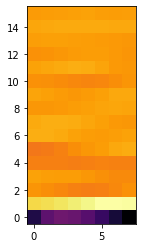

In [19]:
# TEST: Test shorter MFCC

from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [20]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [21]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 13 (16, 8)
Dropped: 19 (16, 12)
Dropped: 44 (16, 4)
Dropped: 51 (16, 11)
Dropped: 78 (16, 15)
Dropped: 83 (16, 8)
Dropped: 99 (16, 15)
Dropped: 133 (16, 15)
Dropped: 146 (16, 9)
Dropped: 205 (16, 7)
Dropped: 231 (16, 6)
Dropped: 250 (16, 11)
Dropped: 263 (16, 15)
Dropped: 285 (16, 11)
Dropped: 308 (16, 12)
Dropped: 311 (16, 13)
Dropped: 317 (16, 9)
Dropped: 333 (16, 15)
Dropped: 338 (16, 12)
Dropped: 360 (16, 15)
Dropped: 363 (16, 10)
Dropped: 372 (16, 11)
Dropped: 400 (16, 9)
Dropped: 401 (16, 11)
Dropped: 413 (16, 12)
Dropped: 417 (16, 15)
Dropped: 444 (16, 10)
Dropped: 448 (16, 11)
Dropped: 463 (16, 15)
Dropped: 474 (16, 13)
Dropped: 475 (16, 13)
Dropped: 496 (16, 14)
Dropped: 501 (16, 3)
Dropped: 520 (16, 15)
Dropped: 538 (16, 12)
Dropped: 542 (16, 14)
Dropped: 555 (16, 13)
Dropped: 575 (16, 13)
Dropped: 582 (16, 7)
Dropped: 585 (16, 10)
Dropped: 611 (16, 10)
Dropped: 623 (16, 15)
Dropped: 633 (16, 14)
Dropped: 634 (16, 11)
Dropped: 639 (16, 6)
Dropped: 684 (16, 9)
Dropped

Dropped: 4569 (16, 14)
Dropped: 4584 (16, 11)
Dropped: 4586 (16, 15)
Dropped: 4597 (16, 12)
Dropped: 4607 (16, 12)
Dropped: 4646 (16, 9)
Dropped: 4664 (16, 11)
Dropped: 4667 (16, 11)
Dropped: 4674 (16, 12)
Dropped: 4677 (16, 13)
Dropped: 4685 (16, 14)
Dropped: 4688 (16, 10)
Dropped: 4698 (16, 8)
Dropped: 4708 (16, 13)
Dropped: 4756 (16, 15)
Dropped: 4783 (16, 4)
Dropped: 4813 (16, 15)
Dropped: 4817 (16, 14)
Dropped: 4828 (16, 11)
Dropped: 4832 (16, 10)
Dropped: 4836 (16, 15)
Dropped: 4838 (16, 10)
Dropped: 4841 (16, 15)
Dropped: 4846 (16, 14)
Dropped: 4880 (16, 13)
Dropped: 4909 (16, 13)
Dropped: 4928 (16, 13)
Dropped: 4947 (16, 10)
Dropped: 4955 (16, 13)
Dropped: 4960 (16, 14)
Dropped: 4992 (16, 10)
Dropped: 5008 (16, 12)
Dropped: 5011 (16, 8)
Dropped: 5018 (16, 15)
Dropped: 5038 (16, 15)
Dropped: 5053 (16, 15)
Dropped: 5054 (16, 10)
Dropped: 5068 (16, 7)
Dropped: 5075 (16, 9)
Dropped: 5095 (16, 13)
Dropped: 5101 (16, 11)
Dropped: 5112 (16, 6)
Dropped: 5129 (16, 11)
Dropped: 5144 (16,

In [22]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [23]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [24]:
len(feature_sets['x_train'])

5710

In [25]:
print(feature_sets['y_val'])

[1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.